### Analysis of data from MSI 310 IMU and comparison with GKV
Here we compare data from MSI 310 IMU (200 Hz) and GKV (100 Hz, 1kHz -> skip 9/10 packets)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from cyber_py3.record import RecordReader
from modules.localization.proto.imu_pb2 import CorrectedImu
from modules.drivers.gnss.proto.imu_pb2 import Imu
import scipy.io

In [2]:
# файл с топиком /apollo/sensor/mtmsystems/imu
msi_imu_topic_record_file = "/media/hard-drive/ownCloud/gnss_imu/msi_with_counter.record.00000"
# файл с остальными топиками
msi_other_record_file = "/media/hard-drive/ownCloud/gnss_imu/msi_310_other.record.00000"

### Read GKV data
We also should convert gyro measurements from rad/sec into degrees/sec

In [3]:
reader = RecordReader(msi_other_record_file)

gkv_data = []

for channelname, msg, datatype, timestamp in reader.read_messages():
    if channelname == "/apollo/sensor/gnss/corrected_imu":
        imu = CorrectedImu()
        imu.ParseFromString(msg)    
        gkv_data.append([imu.imu.linear_acceleration.x, imu.imu.linear_acceleration.y, imu.imu.linear_acceleration.z,
                       imu.imu.angular_velocity.x/np.pi*180, imu.imu.angular_velocity.y/np.pi*180, imu.imu.angular_velocity.z/np.pi*180])
        
gkv_data = np.array(gkv_data)
print(gkv_data.shape)

fps_gkv = 100
time_interval_gkv = gkv_data.shape[0] / fps_gkv
time_axis_gkv = np.linspace(0, time_interval_gkv, num=gkv_data.shape[0])

(84958, 6)


### Read MSI data

In [71]:
reader = RecordReader(msi_imu_topic_record_file)

msi_data = []

old_cnt = 0
cnt_adder = 0

for channelname, msg, datatype, timestamp in reader.read_messages():
      if channelname == "/apollo/sensor/mtmsystems/imu":
            imu = Imu()
            imu.ParseFromString(msg)
            if old_cnt > 65000 and imu.counter < 10:
                cnt_adder += 65535
            elif old_cnt > imu.counter:
                continue
                            
            msi_data.append([imu.linear_acceleration.x, imu.linear_acceleration.y, imu.linear_acceleration.z,
                       imu.angular_velocity.x, imu.angular_velocity.y, imu.angular_velocity.z, imu.counter+cnt_adder])
            
            old_cnt = imu.counter

msi_data = np.array(msi_data)
time_interval = msi_data[-1,6] - msi_data[0,6]
time_axis_msi = (msi_data[:,6] - msi_data[0,6]) / 1000

### Compare

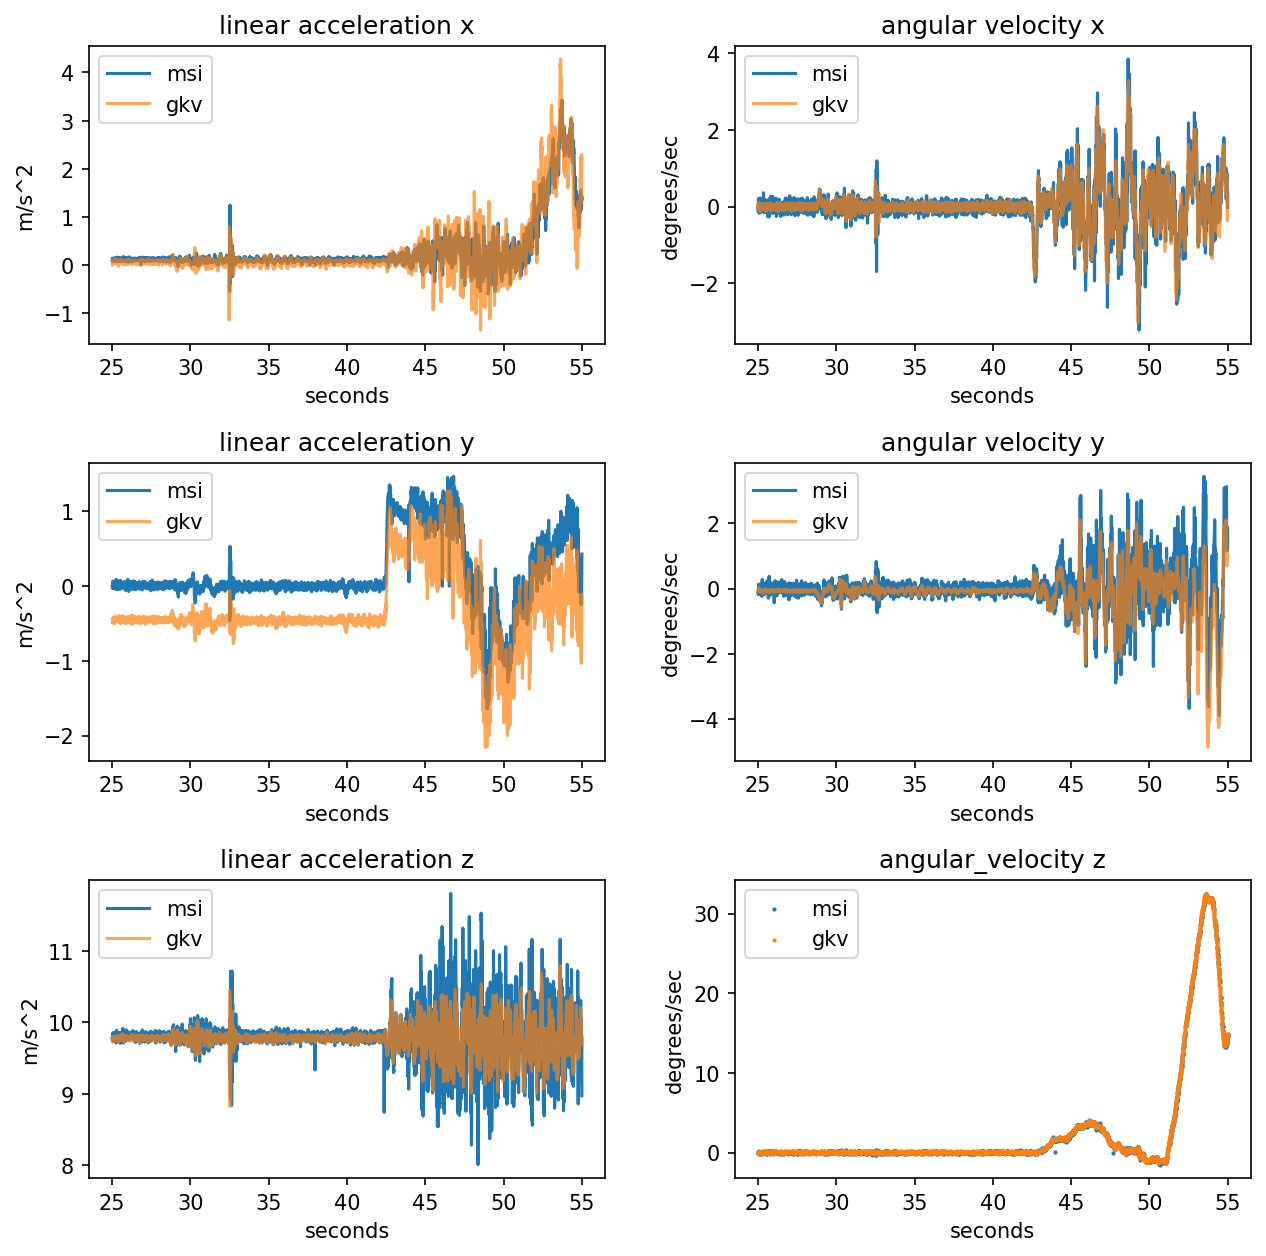

In [104]:
time_start_seconds = 25
time_length_seconds = 30

gkv_offset_seconds = 4.4
gkv_offset_frames = int(gkv_offset_seconds * fps_gkv)
gkv_data_fixed = gkv_data[gkv_offset_frames:, :]
time_interval_gkv = gkv_data_fixed.shape[0]  / fps_gkv
time_axis_gkv = np.linspace(0, time_interval_gkv, num=gkv_data_fixed.shape[0])

gkv_data_mask = np.logical_and(time_axis_gkv > time_start_seconds,
                               time_axis_gkv < (time_start_seconds+time_length_seconds))
gkv_data_piece = gkv_data_fixed[gkv_data_mask]
time_axis_gkv_piece = time_axis_gkv[gkv_data_mask]


msi_data_mask = np.logical_and(time_axis_msi > time_start_seconds,
                               time_axis_msi < (time_start_seconds+time_length_seconds))
msi_data_piece = msi_data[msi_data_mask]
time_axis_msi_piece = time_axis_msi[msi_data_mask]


plt.figure(figsize=(10,10), facecolor='w', edgecolor='k', dpi=150)

plt.subplot(321)
plt.title('linear acceleration x')
plt.ylabel('m/s^2')
plt.xlabel('seconds')
plt.plot(time_axis_msi_piece, -msi_data_piece[:,0], label="msi")
plt.plot(time_axis_gkv_piece, gkv_data_piece[:,0], label="gkv", alpha=0.7)
# plt.scatter(time_axis_msi_piece, -msi_data_piece[:,0], label="msi", s=1)
# plt.scatter(time_axis_gkv_piece, gkv_data_piece[:,0], label="gkv", s=1)
plt.legend()

plt.subplot(323)
plt.title('linear acceleration y')
plt.ylabel('m/s^2')
plt.xlabel('seconds')
plt.plot(time_axis_msi_piece, msi_data_piece[:,1], label="msi")
plt.plot(time_axis_gkv_piece, gkv_data_piece[:,1], label="gkv", alpha=0.7)
plt.legend()

plt.subplot(325)
plt.title('linear acceleration z')
plt.ylabel('m/s^2')
plt.xlabel('seconds')
plt.plot(time_axis_msi_piece, msi_data_piece[:,2], label="msi")
plt.plot(time_axis_gkv_piece, -gkv_data_piece[:,2], label="gkv", alpha=0.7)
plt.legend()

plt.subplot(322)
plt.title('angular velocity x')
plt.ylabel('degrees/sec')
plt.xlabel('seconds')
plt.plot(time_axis_msi_piece, -msi_data_piece[:,3], label="msi")
plt.plot(time_axis_gkv_piece, gkv_data_piece[:,3], label="gkv", alpha=0.7)
plt.legend()

plt.subplot(324)
plt.title('angular velocity y')
plt.ylabel('degrees/sec')
plt.xlabel('seconds')
plt.plot(time_axis_msi_piece, msi_data_piece[:,4], label="msi")
plt.plot(time_axis_gkv_piece, gkv_data_piece[:,4], label="gkv", alpha=0.7)
plt.legend()

plt.subplot(326)
plt.title('angular_velocity z')
plt.ylabel('degrees/sec')
plt.xlabel('seconds')
plt.scatter(time_axis_msi_piece, msi_data_piece[:,5], label="msi", s=1)
plt.scatter(time_axis_gkv_piece, gkv_data_piece[:,5], label="gkv",s=1)
plt.legend()

plt.subplots_adjust(hspace=0.4, wspace=0.25)

plt.savefig("last_plot.png")